# Recharging strategy for an electric vehicle

Whether it is to visit family, take a sightseeing tour or call on business associates, planning a road trip is a familiar and routine task. Here we consider a road trip on a pre-determined route for which need to plan rest and recharging stops. This example demonstrates use of Pyomo disjunctions to model the decisions on where to stop. 

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

## Problem Statement

Given the current location $x$, battery charge $c$, and planning horizon $D$, the task is to plan a series of recharging and rest stops. Data is provided for the location and the charging rate available at each charging stations. The objective is to drive from location $x$ to location $x + D$ in as little time as possible subject to the following constraints:

* To allow for unforeseen events, the state of charge should never drop below 20% of the maximum capacity.
* The the maximum charge is $c_{max} = 80$ kWh.
* For comfort, no more than 4 hours should pass between stops, and that a rest stop should last at least $t^{rest}$.
* Any stop includes a $t^{lost} = 10$ minutes of "lost time".

For this first model we make several simplifying assumptions that can be relaxed as a later time.

* Travel is at a constant speed $v = 100$ km per hour and a constant discharge rate $R = 0.24$ kWh/km
* The batteries recharge at a constant rate determined by the charging station.
* Only consider stops at the recharging stations.

## Modeling

The problem statement identifies four state variables.

* $c$ the current battery charge
* $r$ the elapsed time since the last rest stop
* $t$ elapsed time since the start of the trip
* $x$ the current location

The charging stations are located at positions $d_i$ for $i\in I$ with capacity $C_i$. The arrival time at charging station $i$ is given by

$$
\begin{align*}
c_i^{arr} & = c_{i-1}^{dep} - R (d_i - d_{i-1}) \\
r_i^{arr} & = r_{i-1}^{dep} + \frac{d_i - d_{i-1}}{v} \\
t_i^{arr} & = t_{i-1}^{dep} + \frac{d_i - d_{i-1}}{v} \\
\end{align*}
$$

where the script $t_{i-1}^{dep}$ refers to departure from the prior location. At each charging location there is a decision to make of whether to stop, rest, and rechange. If the decision is positive, then

$$
\begin{align*}
c_i^{dep} & \leq c^{max} \\
r_i^{dep} & = 0 \\
t_i^{dep} & \geq t_{i}^{arr} + t_{lost} + \frac{c_i^{dep} - c_i^{arr}}{C_i} \\
t_i^{dep} & \geq t_{i}^{arr} + t_{rest}
\end{align*}
$$

which account for the battery charge, the lost time and time required for battery charging, and allows for a minimum rest time. On the other hand, if a decision is make to skip the charging and rest opportunity,

$$
\begin{align*}
c_i^{dep} & = c_i^{arr} \\
r_i^{dep} & = r_i^{arr} \\
t_i^{dep} & = t_i^{arr}
\end{align*}
$$

The latter sets of constraints have an exclusive-or relationship. That is, either one or the other of the constraint sets hold, but not both.  

$$
\begin{align*}
\min \quad & t_{n+1}^{arr} \\
\text{s.t.} \quad
    & r_i^{arr}  \leq r^{max} & \forall \, i \in I \\
    & c_i^{arr}  \geq c^{min} & \forall \,i \in I \\
    & c_i^{arr}  = c_{i-1}^{dep} - R (d_i - d_{i-1}) & \forall \,i \in I \\
    & r_i^{arr}  = r_{i-1}^{dep} + \frac{d_i - d_{i-1}}{v} & \forall \,i \in I \\
    & t_i^{arr}  = t_{i-1}^{dep} + \frac{d_i - d_{i-1}}{v} & \forall \,i \in I \\
& \begin{bmatrix}
    c_i^{dep} & \leq & c^{max} \\
    r_i^{dep} & = & 0 \\
    t_i^{dep} & \geq & t_{i}^{arr} + t_{lost} + \frac{c_i^{dep} - c_i^{arr}}{C_i} \\
    t_i^{dep} & \geq & t_{i}^{arr} + t_{rest}
\end{bmatrix}
\veebar
\begin{bmatrix}
    c_i^{dep} = c_i^{arr} \\
    r_i^{dep} = r_i^{arr} \\
    t_i^{dep} = t_i^{arr}
\end{bmatrix} & \forall \, i \in I.
\end{align*}
$$


## Charging Station Information

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# specify number of charging stations
n_charging_stations = 20

# randomly distribute charging stations along a fixed route
np.random.seed(1842)
d = np.round(np.cumsum(np.random.triangular(20, 150, 223, n_charging_stations)), 1)

# randomly assign changing capacities
c = np.random.choice([50, 100, 150, 250], n_charging_stations, p=[0.2, 0.4, 0.3, 0.1])

# assign names to the charging stations
s = [f"S_{i:02d}" for i in range(n_charging_stations)]

stations = pd.DataFrame([s, d, c]).T
stations.columns=["name", "location", "kw"]
display(stations)

,name,location,kw
0,S_00,191.6,150
1,S_01,310.6,100
2,S_02,516.0,50
3,S_03,683.6,50
4,S_04,769.9,50
5,S_05,869.7,100
6,S_06,1009.1,150
7,S_07,1164.7,100
8,S_08,1230.8,100
9,S_09,1350.8,250


## Route Information

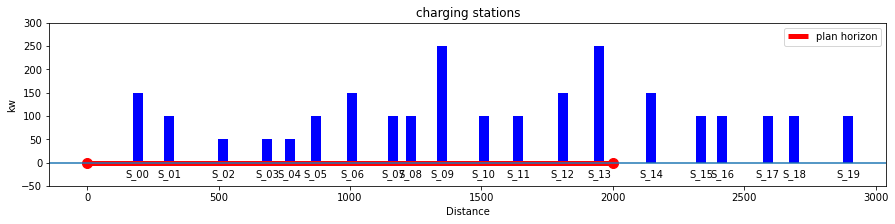

In [3]:
# current location (km) and charge (kw)
x = 0

# planning horizon
D = 2000

# visualize
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

def plot_stations(stations, x, D, ax=ax):
    
    for station in stations.index:
        xs = stations.loc[station, "location"]
        ys = stations.loc[station, "kw"]
        ax.plot([xs, xs], [0, ys], 'b', lw=10, solid_capstyle="butt")
        ax.text(xs, 0-30, stations.loc[station, "name"], ha="center")

    ax.plot([x, x+D], [0, 0], 'r', lw=5, solid_capstyle="butt", label="plan horizon")
    ax.plot([x, x+D], [0, 0], 'r.', ms=20)

    ax.axhline(0)
    ax.set_ylim(-50, 300)
    ax.set_xlabel('Distance')
    ax.set_ylabel('kw')
    ax.set_title("charging stations")
    ax.legend()

plot_stations(stations, x, D)

## Car Information

In [4]:
# charge limits (kw)
c_max = 150
c_min = 0.2 * c_max
c = c_max

# velocity km/hr and discharge rate kwh/km
v = 100.0
R = 0.24

# lost time
t_lost = 10/60
t_rest = 10/60

# rest time
r_max = 3

## Pyomo Model

In [5]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def ev_plan(stations, x, D):
    
    # find stations between x and x + D
    on_route = stations[(stations["location"] >= x) & (stations["location"] <= x + D)]

    m = pyo.ConcreteModel()

    m.n = pyo.Param(default=len(on_route))

    # locations and road segments between location x and x + D
    m.STATIONS = pyo.RangeSet(1, m.n)
    m.LOCATIONS = pyo.RangeSet(0, m.n + 1)
    m.SEGMENTS = pyo.RangeSet(1, m.n + 1)

    # distance traveled
    m.x = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, 10000))

    # arrival and departure charge at each charging station
    m.c_arr = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(c_min, c_max))
    m.c_dep = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(c_min, c_max))

    # arrival and departure times from each charging station
    m.t_arr = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, 100))
    m.t_dep = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, 100))

    # arrival and departure rest from each charging station
    m.r_arr = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, r_max))
    m.r_dep = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, r_max))

    # initial conditions
    m.x[0].fix(x)
    m.t_dep[0].fix(0.0)
    m.r_dep[0].fix(0.0)
    m.c_dep[0].fix(c)
    
    m.D = D

    @m.Param(m.STATIONS)
    def C(m, i):
        return on_route.loc[i-1, "kw"]

    @m.Param(m.LOCATIONS)
    def location(m, i):
        if i == 0:
            return x
        elif i == m.n + 1:
            return x + D
        else:
            return on_route.loc[i-1, "location"]

    @m.Param(m.SEGMENTS)
    def dist(m, i):
        return m.location[i] - m.location[i-1]

    @m.Objective(sense=pyo.minimize)
    def min_time(m):
        return m.t_arr[m.n + 1]

    @m.Constraint(m.SEGMENTS)
    def drive_time(m, i):
        return m.t_arr[i] == m.t_dep[i-1] + m.dist[i]/v

    @m.Constraint(m.SEGMENTS)
    def rest_time(m, i):
        return m.r_arr[i] == m.r_dep[i-1] + m.dist[i]/v

    @m.Constraint(m.SEGMENTS)
    def drive_distance(m, i):
        return m.x[i] == m.x[i-1] + m.dist[i]

    @m.Constraint(m.SEGMENTS)
    def discharge(m, i):
        return m.c_arr[i] == m.c_dep[i-1] - R*m.dist[i]

    @m.Disjunction(m.STATIONS, xor=True)
    def recharge(m, i):
        # list of constraints thtat apply if there is no stop at station i
        disjunct_1 = [m.c_dep[i] == m.c_arr[i],
                      m.t_dep[i] == m.t_arr[i],
                      m.r_dep[i] == m.r_arr[i]]

        # list of constraints that apply if there is a stop at station i
        disjunct_2 = [m.t_dep[i] == t_lost + m.t_arr[i] + (m.c_dep[i] - m.c_arr[i])/m.C[i],
                      m.c_dep[i] >= m.c_arr[i],
                      m.r_dep[i] == 0]

        # return a list disjuncts
        return [disjunct_1, disjunct_2]

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    pyo.SolverFactory('cbc').solve(m)
    
    return m

m = ev_plan(stations, 0, 2000)

results = pd.DataFrame({
    i : {"location": m.x[i](),
         "t_arr": m.t_arr[i](), 
         "t_dep": m.t_dep[i](),
         "c_arr": m.c_arr[i](),
         "c_dep": m.c_dep[i](),
        } for i in m.LOCATIONS
}).T

results["t_stop"] = results["t_dep"] - results["t_arr"]
    
display(results)

,location,t_arr,t_dep,c_arr,c_dep,t_stop
0,0.0,NaN,0.000000,NaN,150.000,NaN
1,191.6,1.916000,2.389227,104.016,150.000,0.473227
2,310.6,3.579227,4.031493,121.440,150.000,0.452267
3,516.0,6.085493,6.252160,100.704,100.704,0.166667
4,683.6,7.928160,8.378507,60.480,74.664,0.450347
5,769.9,9.241507,9.241507,53.952,53.952,0.000000
6,869.7,10.239507,10.740733,30.000,63.456,0.501226
7,1009.1,12.134733,12.848120,30.000,112.008,0.713387
8,1164.7,14.404120,14.570787,74.664,74.664,0.166667
9,1230.8,15.231787,15.231787,58.800,58.800,0.000000


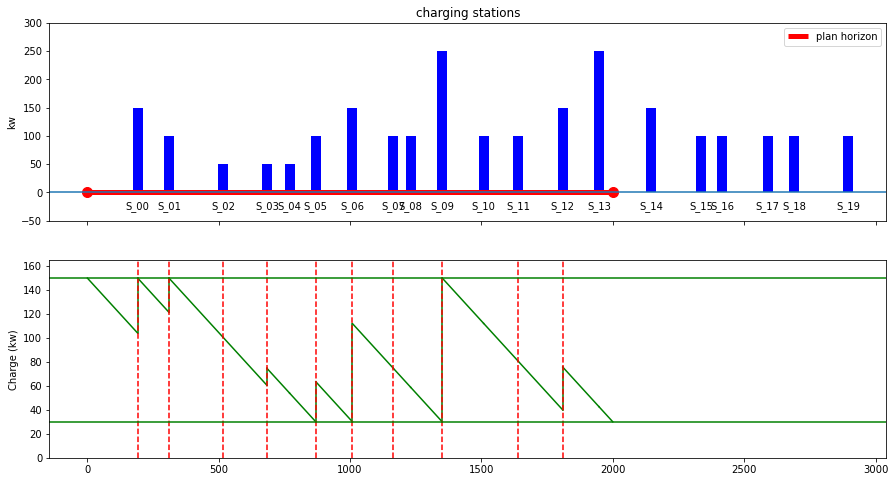

In [6]:
# visualize

def visualize(m):
    
    D = m.D

    results = pd.DataFrame({
        i : {"location": m.x[i](),
             "t_arr": m.t_arr[i](), 
             "t_dep": m.t_dep[i](),
             "c_arr": m.c_arr[i](),
             "c_dep": m.c_dep[i](),
            } for i in m.LOCATIONS
    }).T
    
    results["t_stop"] = results["t_dep"] - results["t_arr"]

    fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    # plot stations
    for station in stations.index:
        xs = stations.loc[station, "location"]
        ys = stations.loc[station, "kw"]
        ax[0].plot([xs, xs], [0, ys], 'b', lw=10, solid_capstyle="butt")
        ax[0].text(xs, 0-30, stations.loc[station, "name"], ha="center")

    # plot planning horizon
    ax[0].plot([x, x+D], [0, 0], 'r', lw=5, solid_capstyle="butt", label="plan horizon")
    ax[0].plot([x, x+D], [0, 0], 'r.', ms=20)

    # annotations
    ax[0].axhline(0)
    ax[0].set_ylim(-50, 300)
    ax[0].set_ylabel('kw')
    ax[0].set_title("charging stations")
    ax[0].legend()

    # plot battery charge
    for i in m.SEGMENTS:
        xv = [results.loc[i-1, "location"], results.loc[i, "location"]]
        cv = [results.loc[i-1, "c_dep"], results.loc[i, "c_arr"]]
        ax[1].plot(xv, cv, 'g')

    # plot charge at stations
    for i in m.STATIONS:
        xv = [results.loc[i, "location"]]*2
        cv = [results.loc[i, "c_arr"], results.loc[i, "c_dep"]]
        ax[1].plot(xv, cv, 'g')
        
    # mark stop locations
    for i in m.STATIONS:
        if results.loc[i, "t_stop"] > 0:
            ax[1].axvline(results.loc[i, "location"], color='r', ls='--')

    # show constraints on battery charge
    ax[1].axhline(c_max, c='g')
    ax[1].axhline(c_min, c='g')
    ax[1].set_ylim(0, 1.1*c_max)
    ax[1].set_ylabel('Charge (kw)')
    
visualize(ev_plan(stations, 0, 2000))

## Suggested Exercises

1. Does increasing the battery capacity $c^{max}$ significantly reduce the time required to travel 2000 km? Explain what you observe.

2. "The best-laid schemes of mice and men go oft awry" (Robert Burns, "To a Mouse"). Modify this model so that it can be used to update a plans in response to real-time measurements. How does the charging strategy change as a function of planning horizon $D$?